<a href="https://colab.research.google.com/github/TobiPrae/customer_segmentation/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

import gc

# machine learning magic for unsupervised learning part
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# machine learning magic for supervised learning part
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBRegressor

import sklearn.metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score



import tensorflow as tf
from tensorflow import keras

# To pickle preparation models
from pickle import dump, load

# To identify elbow point
!pip install kneed
from kneed import KneeLocator

print("Libraries successfully imported")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries successfully imported


In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Everything successfully set up")

Everything successfully set up


# Load Data

In [3]:
'''
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list[:]:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
'''

'\n# Get list of every available file in google drive\nfile_list = drive.ListFile({\'q\': "\'root\' in parents and trashed=false"}).GetList()\nfor file1 in file_list[:]:\n  print(\'title: %s, id: %s\' % (file1[\'title\'], file1[\'id\']))\n'

In [4]:
'''
# download demographic data
download_data = drive.CreateFile({'id': '135UcsbUyLcwS16QHa7lFcXHKhuy7HwWF'})
download_data.GetContentFile('azdias.csv')  
df_azdias = pd.read_csv('azdias.csv', engine="python", sep=';')

print(df_azdias.shape)
'''

'\n# download demographic data\ndownload_data = drive.CreateFile({\'id\': \'135UcsbUyLcwS16QHa7lFcXHKhuy7HwWF\'})\ndownload_data.GetContentFile(\'azdias.csv\')  \ndf_azdias = pd.read_csv(\'azdias.csv\', engine="python", sep=\';\')\n\nprint(df_azdias.shape)\n'

In [5]:
'''
# download customer data
download_data = drive.CreateFile({'id': '1eDq76GDZLXeonowxPrbwF-EHZwvaENLK'})
download_data.GetContentFile('customers.csv')  
df_customers = pd.read_csv('customers.csv', engine="python", sep=';')

print(df_customers.shape)
'''

'\n# download customer data\ndownload_data = drive.CreateFile({\'id\': \'1eDq76GDZLXeonowxPrbwF-EHZwvaENLK\'})\ndownload_data.GetContentFile(\'customers.csv\')  \ndf_customers = pd.read_csv(\'customers.csv\', engine="python", sep=\';\')\n\nprint(df_customers.shape)\n'

In [6]:
'''
# download attribute values and clean them
download_data = drive.CreateFile({'id': '1wFNhCQm7Cv9CGJ7Pm_RbtrJdnLb4zyuC'})
download_data.GetContentFile('attributes_values.xlsx')  
df_attributes_values = pd.read_excel('attributes_values.xlsx', names=["None", "attribute", "description", "value", "meaning"])
df_attributes_values = df_attributes_values.drop(columns=['None'])[1:]
# Forward filling the attribute values df for better filtering/slicing
df_attributes_values["attribute"] = df_attributes_values["attribute"].fillna(method="ffill")
df_attributes_values["description"] = df_attributes_values["description"].fillna(method="ffill")
print(df_attributes_values.shape)
'''

'\n# download attribute values and clean them\ndownload_data = drive.CreateFile({\'id\': \'1wFNhCQm7Cv9CGJ7Pm_RbtrJdnLb4zyuC\'})\ndownload_data.GetContentFile(\'attributes_values.xlsx\')  \ndf_attributes_values = pd.read_excel(\'attributes_values.xlsx\', names=["None", "attribute", "description", "value", "meaning"])\ndf_attributes_values = df_attributes_values.drop(columns=[\'None\'])[1:]\n# Forward filling the attribute values df for better filtering/slicing\ndf_attributes_values["attribute"] = df_attributes_values["attribute"].fillna(method="ffill")\ndf_attributes_values["description"] = df_attributes_values["description"].fillna(method="ffill")\nprint(df_attributes_values.shape)\n'

In [7]:
'''
# download attribute information levels and clean them
download_data = drive.CreateFile({'id': '1icPBxHTV0zysKvQSJhSDPDhyH8Qd3uqW'})
download_data.GetContentFile('information_levels_attributes.xlsx')  
df_information_levels = pd.read_excel('information_levels_attributes.xlsx', names=["None", "Information_Level", "attribute", "description", "additional_notes"])
df_information_levels = df_information_levels.drop(columns=["None"])[1:]
print(df_information_levels.shape)
'''

'\n# download attribute information levels and clean them\ndownload_data = drive.CreateFile({\'id\': \'1icPBxHTV0zysKvQSJhSDPDhyH8Qd3uqW\'})\ndownload_data.GetContentFile(\'information_levels_attributes.xlsx\')  \ndf_information_levels = pd.read_excel(\'information_levels_attributes.xlsx\', names=["None", "Information_Level", "attribute", "description", "additional_notes"])\ndf_information_levels = df_information_levels.drop(columns=["None"])[1:]\nprint(df_information_levels.shape)\n'

In [8]:

# download demographic data
download_data = drive.CreateFile({'id': '1QwV131IP74EHaBrKAnlcGk4EaMwBsTHE'})
download_data.GetContentFile('meta_data.xlsx')  
meta_data = pd.read_excel('meta_data.xlsx')
meta_data = meta_data.iloc[:365, :]
print(meta_data.shape)

(365, 16)


In [9]:
# download train data
download_data = drive.CreateFile({'id': '1YclR47YPa6Q5S98bvMNflPcb8h0LQC_I'})
download_data.GetContentFile('mailout_train.csv.csv')  
df_train = pd.read_csv('mailout_train.csv.csv', engine="python", sep=';')

print(df_train.shape)

(42962, 367)


In [10]:
# download training data
download_data = drive.CreateFile({'id': '1mpHKYwfFVuQ1kBQroxL3HYnMCcMxfH9_'})
download_data.GetContentFile('mailout_test.csv')  
df_test = pd.read_csv('mailout_test.csv', engine="python", sep=';')

print(df_test.shape)

(42833, 366)


# Functions

In [11]:
def get_description(col):
  '''
  Gets description for given column.

  Args:
  - col: column name

  Returns:
  - description or "No description available."
  '''
  if(df_attributes_values.loc[df_attributes_values["attribute"] == col].shape[0] == 0):
    return "No description available."
  else:
    return df_attributes_values.loc[df_attributes_values["attribute"] == col]["description"].values[0]

In [12]:
def create_meta_dataframe():
  '''
  Creates data frame with meta information.

  Args:
  - Nothing

  Returns:
  - meta_df
  '''
  meta_df = pd.DataFrame(df_azdias.columns.tolist())
  meta_df = meta_df.rename(columns={0: "column_name"})
  meta_df["na_percentage"] = meta_df["column_name"].apply(lambda x: round(df_azdias[x].isna().sum()/df_azdias.shape[0], 4))
  meta_df["dtypes"] =  meta_df["column_name"].apply(lambda x: set(df_azdias[x].map(type).tolist()))
  meta_df["n_dtypes"] = meta_df["column_name"].apply(lambda x: len(set(df_azdias[x].map(type).tolist())))
  meta_df["unique_values"] = meta_df["column_name"].apply(lambda x: len(df_azdias[x].value_counts()))
  meta_df["description"] =  meta_df["column_name"].apply(get_description)
  meta_df["action"] = "Keep"
  meta_df["reason"] = "None"
  return meta_df

In [13]:
def transform_PRAEGENDE_JUGENDJAHRE(x):
  '''
    Transform value for feature PRAEGENDE_JUGENDJAHRE.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2]):
    return 40
  elif(x in [3, 4]):
    return 50
  elif(x in [5, 6, 7]):
    return 60
  elif(x in [8, 9]):
    return 70
  elif(x in [10, 11, 12, 13]):
    return 80
  elif(x in [14, 15]):
    return 90

In [14]:
def transform_CAMEO_INTL_2015(x):
  '''
  Transform value for feature CAMEO_INTL_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(str(x)[0] == '1'):
    return '1'
  if(str(x)[0] == '2'):
    return '2'
  if(str(x)[0] == '3'):
    return '3'
  if(str(x)[0] == '4'):
    return '4'
  if(str(x)[0] == '5'):
    return '5'
  else:
    return np.nan

In [15]:
def transform_CAMEO_DEUG_2015(x):
  '''
  Transform value for feature CAMEO_DEUG_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x == 'X'):
    return np.nan
  else:
    return x

In [16]:
def transformation_pipeline(df, column_threshold = 0.3, row_threshold = 0.3):

  print(f"shape before: {df.shape}")

  # Drop ID column
  df = df.drop(columns="LNR")
  print("index droped")

  # Drop columns with nan percentage over certain threshold
  drop_columns = meta_data.loc[meta_data["na_percentage_azdias"] > column_threshold]["column_name"].tolist()
  df = df.drop(columns=drop_columns)
  print(f"columns with nan threshold of {column_threshold} droped: ")
  print(drop_columns)

  # Drop rows with nan percentage over certain threshold
  df["row_nan_percentage"] = pd.Series(df.index).apply(lambda x: df.iloc[x, :].isna().sum()/df.shape[1])
  df = df.loc[df["row_nan_percentage"] < row_threshold]
  print(f"rows with nan threshold of {row_threshold} droped")  

  ### Drop columns with unknown data types and no description ###

  unknown_cols = meta_data.loc[meta_data["type"] == "Unknown"]["column_name"].tolist()
  df_transformed = df.drop(columns=list(set(unknown_cols).intersection(set(df.columns))))
  print("columns with unknown datatype droped")

  ### Transformation of binary columns ###

  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].replace(2, 0) 
  df_transformed["GREEN_AVANTGARDE"] = df_transformed["GREEN_AVANTGARDE"].fillna(df_transformed["GREEN_AVANTGARDE"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].apply(lambda x: 1 if x == 'W' else (0 if 'O' else x))
  df_transformed["SOHO_KZ"] = df_transformed["SOHO_KZ"].fillna(df_transformed["SOHO_KZ"].mode().values[0])
  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].fillna(df_transformed["ANREDE_KZ"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].fillna(df_transformed["OST_WEST_KZ"].mode().values[0])
  print("binary columns transformed")

  ### Transformation of numerical columns ###

  numerical_columns = meta_data.loc[meta_data["type"] == "Numerical"]["column_name"].tolist()
  for col in list(set(numerical_columns).intersection(set(df_transformed.columns))):
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("numeric columns transformed")

  ### Transformation of ordinal columns ###

  # Transform ordinal columns that have no value or -1 for unknown
  ordinal_no_unknown_cols = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] != 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_no_unknown_cols = list(set(ordinal_no_unknown_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_no_unknown_cols:
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("ordinal columns that have no value for unkown transformed")

  # Transform ordinal colums that have 9 or -1 values for unknow
  ordinal_9_1_cols = meta_data.loc[(meta_data["9 unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_9_1_cols = list(set(ordinal_9_1_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_9_1_cols:
    df_transformed[col] = df_transformed[col].replace(9, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 9 or -1 values for unknow transformed")

  # Transform ordinal columns that have 0 or -1 values for unknown
  ordinal_0_1_cols = meta_data.loc[(meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_0_1_cols = list(set(ordinal_0_1_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_0_1_cols:
    df_transformed[col] = df_transformed[col].replace(0, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 0 or -1 values for unknow transformed")

  ### Transformation of categorical features ###

  # Transform categorical columns that have 0 values for unknown
  categorical_0_columns = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Categorical")]["column_name"].tolist()
  categorical_0_columns = list(set(categorical_0_columns).intersection(set(df_transformed.columns)))
  for col in categorical_0_columns:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan, 0: np.nan})
  print("categorical columns that have 0 values for unknown transformed")

  # Transform "PRAEGENDE_JUGENDJAHRE"
  df_transformed["PRAEGENDE_JUGENDJAHRE"] = df_transformed["PRAEGENDE_JUGENDJAHRE"].apply(transform_PRAEGENDE_JUGENDJAHRE)
  print('"PRAEGENDE_JUGENDJAHRE" transformed')

  # Transform "ZABEOTYP"
  df_transformed["ZABEOTYP"] = df_transformed["ZABEOTYP"].replace({9: np.nan})
  print('"ZABEOTYP" transformed')

  # Transform "D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"
  cat_temp = ["D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"]
  cat_temp = list(set(cat_temp).intersection(set(df_transformed.columns)))
  for col in cat_temp:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan})
  print('"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed')

  # Drop "CAMEO_DEU_2015" and "AGER_TYP"
  df_transformed = df_transformed.drop(columns=["CAMEO_DEU_2015", "AGER_TYP"])
  print('"CAMEO_DEU_2015" and "AGER_TYP" droped')

  # Transform "CAMEO_INTL_2015"
  df_transformed["CAMEO_INTL_2015"] = df_transformed["CAMEO_INTL_2015"].apply(transform_CAMEO_INTL_2015)
  print("CAMEO_INTL_2015 transformed")

  # Transform "CAMEO_DEUG_2015"
  df_transformed["CAMEO_DEUG_2015"] = df_transformed["CAMEO_DEUG_2015"].apply(transform_CAMEO_DEUG_2015)
  print("CAMEO_DEUG_2015 transformed")

  # Create dummies
  cat_cols = meta_data.loc[meta_data["type"] == "Categorical"]["column_name"].tolist()
  print(cat_cols)
  dummy_cols = list(set(cat_cols).intersection(set(df_transformed.columns)))
  print(dummy_cols)
  for col in dummy_cols:
    col_dum_df = pd.get_dummies(df_transformed[col], prefix=col, dummy_na=True)
    df_transformed = pd.concat([df_transformed, col_dum_df], axis=1)

  df_transformed = df_transformed.drop(columns=dummy_cols)
  print("Dummies created")

  # Transform everything to float
  df_transformed = df_transformed.astype(float)

  print(f"shape after: {df_transformed.shape}")
  return df_transformed



# Part 0: Clean and Standardize Data

### Plot meta data


In [ ]:
meta_data

,column_name,na_percentage_azdias,na_percentage_customers,dtypes_azdias,dtypes_customers,n_dtypes_azdias,n_dtypes_customers,unique_values_azdias,unique_values_customers,description,type,9 unknown,0 unknown,-1 unknown,action,reason
0,AGER_TYP,0.0000,0.0000,{<class 'int'>},{<class 'int'>},1.0,1.0,5.0,5.0,best-ager typology,Categorical,NaN,x,x,Drop,To many nans
1,AKT_DAT_KL,0.0825,0.2431,{<class 'float'>},{<class 'float'>},1.0,1.0,9.0,9.0,No description available.,Unknown,NaN,NaN,NaN,Drop,None
2,ALTER_HH,0.0825,0.2431,{<class 'float'>},{<class 'float'>},1.0,1.0,22.0,21.0,main age within the household,Ordinal,NaN,NaN,NaN,"Clean, impute median",None
3,ALTER_KIND1,0.9090,0.9386,{<class 'float'>},{<class 'float'>},1.0,1.0,17.0,17.0,No description available.,Numerical,NaN,NaN,NaN,Drop,To many nans
4,ALTER_KIND2,0.9669,0.9734,{<class 'float'>},{<class 'float'>},1.0,1.0,17.0,17.0,No description available.,Numerical,NaN,NaN,NaN,Drop,To many nans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,VK_ZG11,0.0852,0.2498,{<class 'float'>},{<class 'float'>},1.0,1.0,11.0,11.0,No description available.,Unknown,NaN,NaN,NaN,Drop,None
361,W_KEIT_KIND_HH,0.1207,0.2804,{<class 'float'>},{<class 'float'>},1.0,1.0,7.0,7.0,likelihood of a child present in this household,Ordinal,NaN,x,x,"Clean, impute median",None
362,WOHNDAUER_2008,0.0825,0.2431,{<class 'float'>},{<class 'float'>},1.0,1.0,9.0,9.0,length of residence,Ordinal,NaN,x,x,"Clean, impute median",None
363,WOHNLAGE,0.1045,0.2605,{<class 'float'>},{<class 'float'>},1.0,1.0,8.0,8.0,residential-area,Ordinal,NaN,x,x,"Clean, impute median",None


In [ ]:
meta_data["type"].value_counts()

Ordinal        285
Unknown         49
Categorical     14
Numerical       13
Binary           4
Name: type, dtype: int64

In [ ]:
meta_data["n_dtypes_azdias"].value_counts()

1.0    359
2.0      6
Name: n_dtypes_azdias, dtype: int64

In [ ]:
meta_data["na_percentage_azdias"].value_counts()

0.1187    116
0.0000     92
0.1496     64
0.0054     19
0.1045     14
0.0825     11
0.2885      9
0.1307      7
0.1091      6
0.0852      3
0.1052      3
0.1360      3
0.1111      3
0.1097      2
0.1207      2
0.0206      1
0.2950      1
0.9986      1
0.1088      1
0.0830      1
0.7340      1
0.9090      1
0.0575      1
0.6560      1
0.9669      1
0.9931      1
Name: na_percentage_azdias, dtype: int64

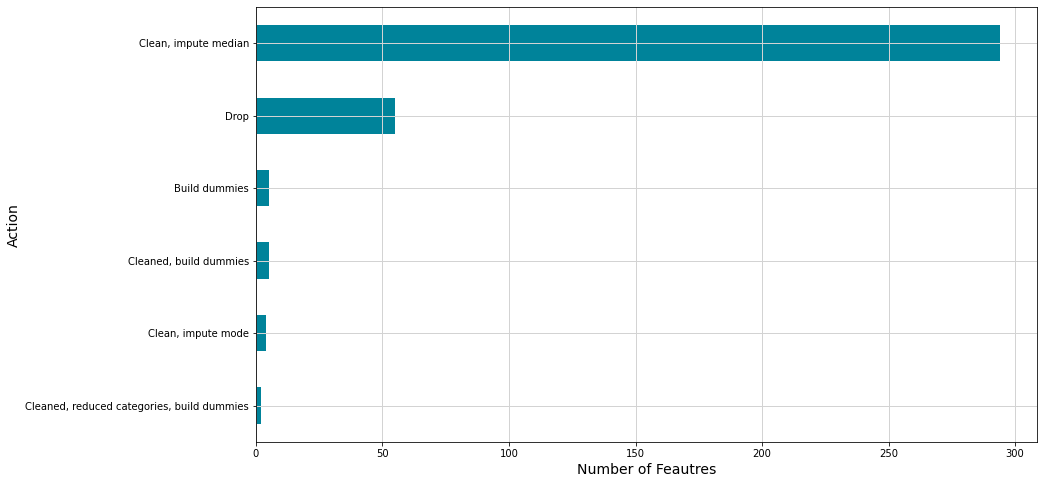

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
fig = meta_data["action"].value_counts().sort_values().plot(kind = 'barh', color='#00839A')
plt.xlabel('Number of Feautres', fontsize=14)
plt.ylabel('Action', fontsize=14)
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

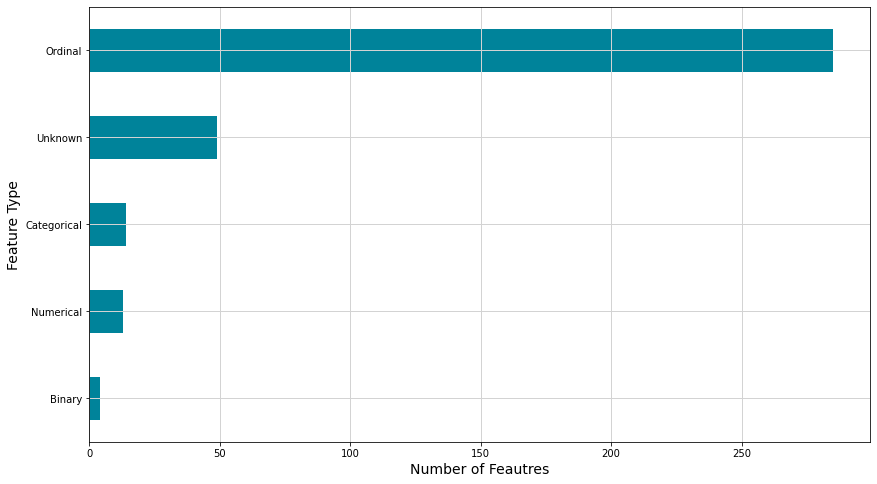

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
fig = meta_data["type"].value_counts().sort_values().plot(kind = 'barh', color='#00839A')
plt.xlabel('Number of Feautres', fontsize=14)
plt.ylabel('Feature Type', fontsize=14)
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

### Transform data

In [ ]:
# Transform df_azdias
df_azdias_transformed = transformation_pipeline(df_azdias, column_threshold = 0.2, row_threshold = 0.1)

shape before: (891221, 366)
index droped
columns with nan threshold of 0.2 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
rows with nan threshold of 0.1 droped
columns with unknown datatype droped
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_201

In [ ]:
# Transform df_customers
#df_customers = df_customers.drop(columns=["PRODUCT_GROUP", "CUSTOMER_GROUP", "ONLINE_PURCHASE"])
df_customers_transformed = transformation_pipeline(df_customers, column_threshold = 0.2, row_threshold = 0.1)

shape before: (191652, 366)
index droped
columns with nan threshold of 0.2 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
rows with nan threshold of 0.1 droped
columns with unknown datatype droped
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_201

### Get different columns and add them

In [ ]:
# Get different columns
set(scaled_df.columns).difference(set(df_customers_transformed.columns))

{'GEBAEUDETYP_5.0'}

In [ ]:
# Get index of differenct column
scaled_df.columns.get_loc('GEBAEUDETYP_5.0') 

298

In [ ]:
# Inset column
df_customers_transformed.insert(loc=298, column='GEBAEUDETYP_5.0', value=0)

### Scale demographic data

In [ ]:
# Create and fit scaler
cols = df_azdias_transformed.columns.tolist()
scaler = StandardScaler()
scaler.fit(df_azdias_transformed.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
# Save the scaler
dump(scaler, open('scaler.pkl', 'wb'))
model_files = drive.CreateFile({'title' : 'scaler.pkl'})
model_files.SetContentFile('scaler.pkl')
model_files.Upload()
drive.CreateFile({'id': model_files.get('scaler.pkl')})

GoogleDriveFile({'id': None})

In [ ]:
# Scale features
scaled_features = scaler.transform(df_azdias_transformed.values)

# Free some memory
del df_azdias
del df_azdias_transformed
gc.collect()

# Create df
scaled_df = pd.DataFrame(scaled_features, columns=cols)

In [ ]:
start = 0
step = 10000
end = step

for i in range(1, 81):
  if(i in [10, 20, 30, 40, 50, 60, 70, 80]):
    print(f"Slice {i}")
  scaled_df.iloc[start:end,:].to_csv(f"df_azdias_scaled_{i}.csv", index=False)
  files = drive.CreateFile({'title' : f"df_azdias_scaled_{i}.csv"})
  files.SetContentFile(f"df_azdias_scaled_{i}.csv")
  files.Upload()
  drive.CreateFile({'id': files.get(f"df_azdias_scaled_{i}.csv")})
  start += step
  end += step
print("upload completed")

Slice 10
Slice 20
Slice 30
Slice 40
Slice 50
Slice 60
Slice 70
Slice 80
upload completed


# Part 1: Customer Segmentation Report

### PCA Analysis

In [ ]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
ticker=0
data=dict()
for file1 in file_list:
  if(ticker == 90):
    break
  else:
    data[file1['title']] = file1['id']
  ticker+=1

In [ ]:
# Load data
download_data = drive.CreateFile({'id': data[f"df_azdias_scaled_{1}.csv"]})
download_data.GetContentFile(f"df_azdias_scaled_{1}.csv")  
scaled_df = pd.read_csv(f"df_azdias_scaled_{1}.csv")

for i in range(2, 81):
  if(i in [10, 20, 30, 40, 50, 60, 70, 80]):
    print(f"Slice {i}")
  download_data = drive.CreateFile({'id': data[f"df_azdias_scaled_{i}.csv"]})
  download_data.GetContentFile(f"df_azdias_scaled_{i}.csv")  
  temp = pd.read_csv(f"df_azdias_scaled_{i}.csv")

  scaled_df = pd.concat([scaled_df, temp], axis=0)

print(scaled_df.shape)
print(sum(scaled_df.isna().sum()))
scaled_df.head(3)

Slice 10
Slice 20
Slice 30
Slice 40
Slice 50
Slice 60
Slice 70
Slice 80
(785421, 385)
0


,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBE

In [ ]:
explained_var = 0.9
pca = PCA(explained_var)
pca.fit(np.array(scaled_df))

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Save pca
dump(pca, open('pca.pkl', 'wb'))
model_files = drive.CreateFile({'title' : 'pca.pkl'})
model_files.SetContentFile('pca.pkl')
model_files.Upload()
drive.CreateFile({'id': model_files.get('pca.pkl')})

GoogleDriveFile({'id': None})

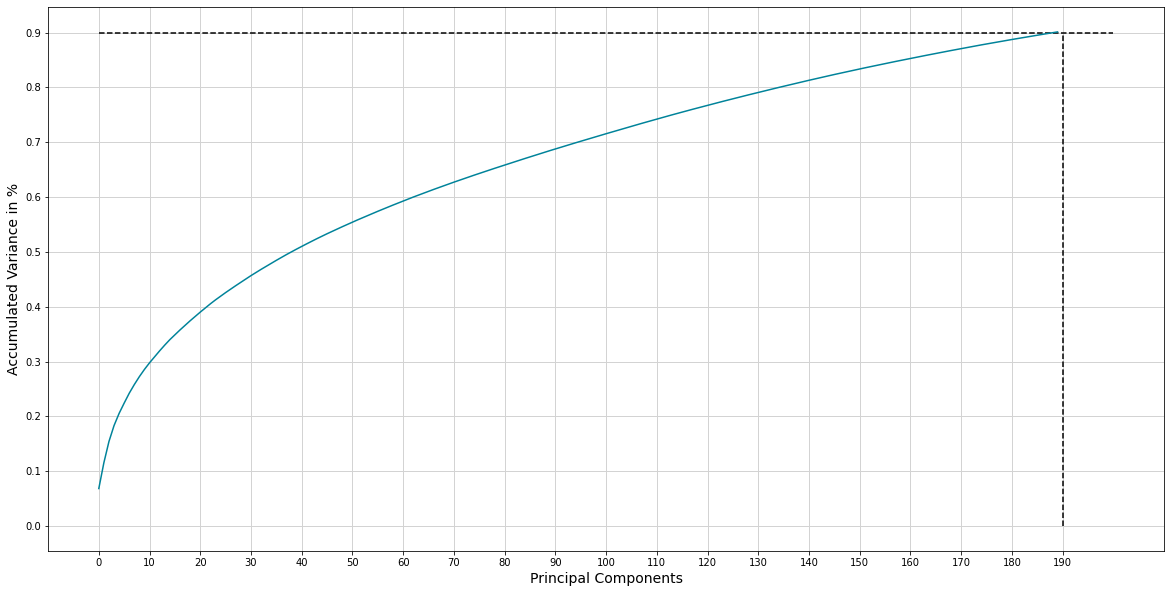

In [ ]:
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.plot(np.cumsum(pca.explained_variance_ratio_), color='#00839A')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Accumulated Variance in %', fontsize=14)
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 200, step=10))
ax.vlines(pca.n_components_, 0, 0.9, color='black', linestyle='--')
ax.hlines(explained_var, 0, 200, color='black', linestyle='--')
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

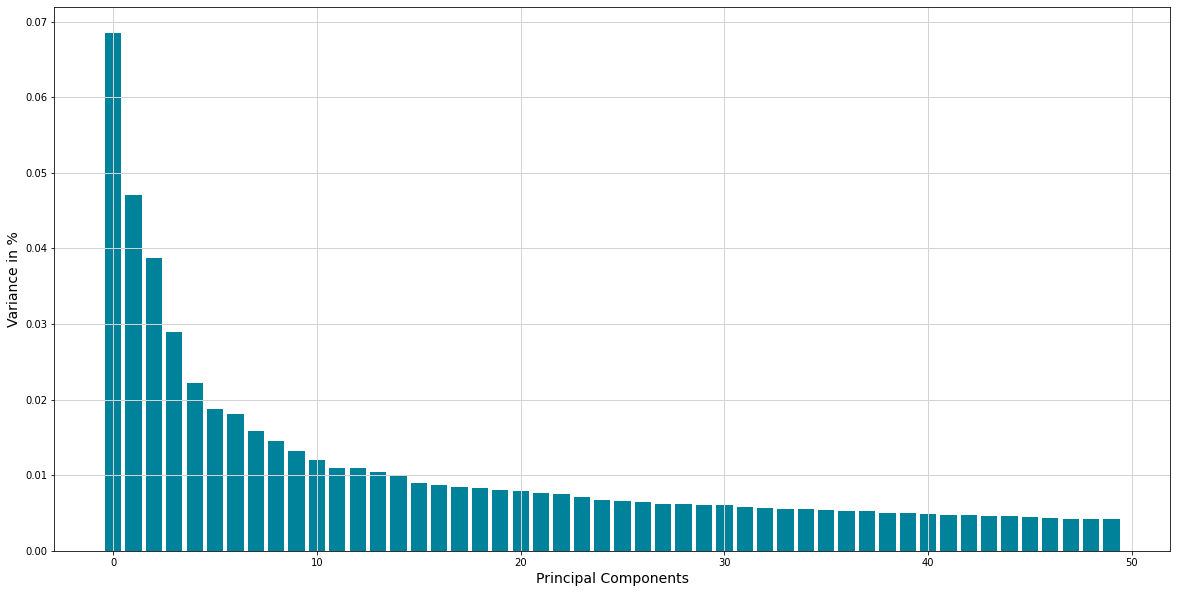

In [ ]:
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.bar(features[:50], pca.explained_variance_ratio_[:50], color='#00839A')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance in %', fontsize=14)
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

In [ ]:
print(pca.explained_variance_ratio_[:4])

[0.0684943  0.0470646  0.03873299 0.02894438]


In [ ]:
principal_component_1 = pca.components_[0]
principal_component_2 = pca.components_[1]
principal_component_3 = pca.components_[2]
principal_component_4 = pca.components_[3]

In [ ]:
### Principal component 1
print("Principal component 1")

temp = list(principal_component_1)
pc_1_max_indices = []
pc_1_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_1_max_indices.append(max_index)
  pc_1_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 1:")
for i in pc_1_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 1:")
for i in pc_1_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 1
_______________________________________________________
High positive influence on principal component 1:
- MOBI_REGIO
- LP_LEBENSPHASE_GROB
- KBA05_ANHANG
_______________________________________________________
High negative influence on principal component 1:
- HH_EINKOMMEN_SCORE
- PLZ8_ANTG1
- OST_WEST_KZ


In [ ]:
### Principal component 2
print("Principal component 2")

temp = list(principal_component_2)
pc_2_max_indices = []
pc_2_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_2_max_indices.append(max_index)
  pc_2_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 1:")
for i in pc_2_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 1:")
for i in pc_2_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 2
_______________________________________________________
High positive influence on principal component 1:
- KBA13_HERST_BMW_BENZ
- KBA13_SEG_MITTELKLASSE
- KBA13_MAZDA
_______________________________________________________
High negative influence on principal component 1:
- KBA13_SITZE_5
- KBA13_SITZE_4
- KBA13_SEG_WOHNMOBILE


In [ ]:
### Principal component 3
print("Principal component 3")

temp = list(principal_component_3)
pc_3_max_indices = []
pc_3_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_3_max_indices.append(max_index)
  pc_3_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 3:")
for i in pc_3_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 3:")
for i in pc_3_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 3
_______________________________________________________
High positive influence on principal component 3:
- ONLINE_AFFINITAET
- FINANZ_MINIMALIST
- D19_GESAMT_ANZ_24
_______________________________________________________
High negative influence on principal component 3:
- D19_GESAMT_ONLINE_DATUM
- D19_VERSAND_OFFLINE_DATUM
- D19_GESAMT_DATUM


In [ ]:
### Principal component 4
print("Principal component 4")

temp = list(principal_component_4)
pc_4_max_indices = []
pc_4_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_4_max_indices.append(max_index)
  pc_4_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 4:")
for i in pc_4_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 4:")
for i in pc_4_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 4
_______________________________________________________
High positive influence on principal component 4:
- ALTERSKATEGORIE_GROB
- FINANZ_UNAUFFAELLIGER
- RETOURTYP_BK_S
_______________________________________________________
High negative influence on principal component 4:
- FINANZ_SPARER
- SEMIO_RAT
- SEMIO_PFLICHT


In [ ]:
pca_components = pd.DataFrame(pca.transform(np.array(scaled_df)))

### Define clusters and apply kmeans model to demographic and to customer data

In [ ]:
k_range = range(1, 26)
inertia_list = []
for k in k_range:
  start_time = time.time()
  print(f"k = {k}")

  # Build model
  model = KMeans(n_clusters=k)
    
  # Fit model to samples
  model.fit(pca_components)

  # Append inertia
  inertia_list.append(model.inertia_)

  end_time = time.time()
  print(f"total time taken model fitting with k = {k}: {end_time - start_time} seconds (inertia {model.inertia_})")
  print("________________________________________________________________________________")

k = 1
total time taken model fitting with k = 1: 17.48241138458252 seconds (inertia 249904426.70263654)
________________________________________________________________________________
k = 2
total time taken model fitting with k = 2: 82.69333744049072 seconds (inertia 236357555.78837848)
________________________________________________________________________________
k = 3
total time taken model fitting with k = 3: 134.0977544784546 seconds (inertia 230042898.76172063)
________________________________________________________________________________
k = 4
total time taken model fitting with k = 4: 181.87414932250977 seconds (inertia 225473565.41444647)
________________________________________________________________________________
k = 5
total time taken model fitting with k = 5: 204.69613671302795 seconds (inertia 221935325.01283696)
________________________________________________________________________________
k = 6
total time taken model fitting with k = 6: 270.3220920562744 second

[249904426.70263654, 236357555.78837848, 230042898.76172063, 225473565.41444647, 221935325.01283696, 219458170.76433942, 217146530.07857728, 215339186.5471797, 213700107.93316317, 212008967.7597235, 210753215.4772089, 208849149.29825446, 207897929.4418377, 208059941.71400428, 206308601.0505295, 204882934.36994138, 204810400.01672164, 203375228.7461338, 202962661.72393396, 202944667.4249806, 202251996.49362296, 201807669.10658404, 200608983.59538993, 200791228.77332386, 199936277.72829846]


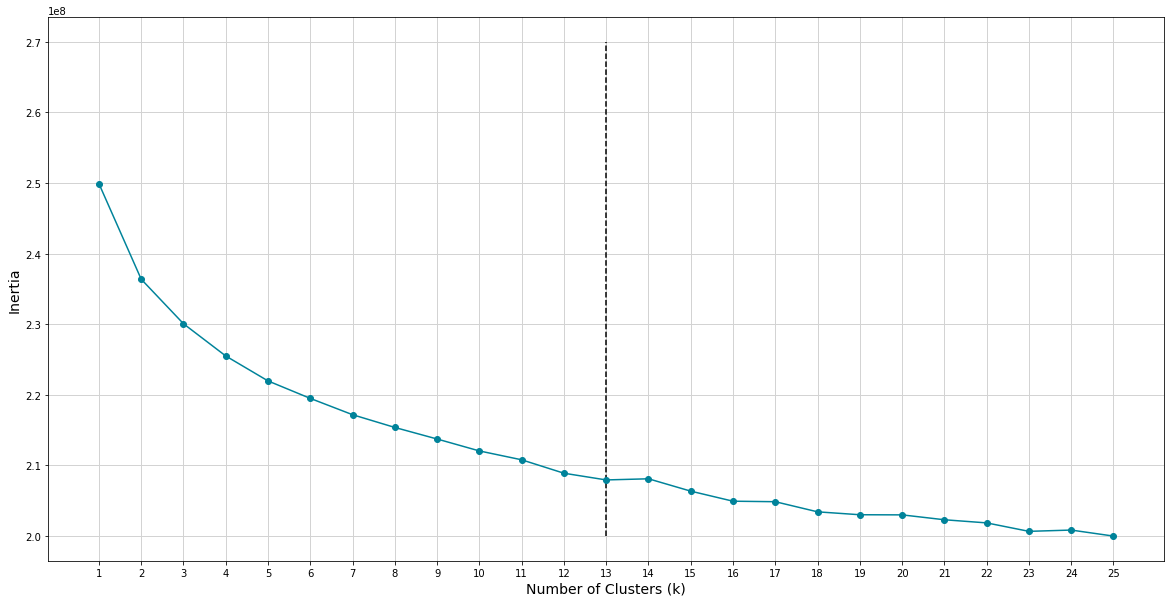

In [ ]:
print(inertia_list)

# Using kneedle to determine optimal number of cluster based on "elbow method"
#kneedle = KneeLocator(k_range, inertia_list, curve="convex", direction="decreasing")
#elbow_point = kneedle.elbow
elbow_point = 13

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.plot(k_range, inertia_list, '-o', color='#00839A')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(k_range)
ax.vlines(elbow_point, 200000000, 270000000, color='black', linestyle='--')
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

In [ ]:
### Train model with k = elbow point

# Build model
model = KMeans(n_clusters=13)
    
# Fit model to samples
model.fit(pca_components)

# Get labels
labels = model.labels_

# Transform labels to df
labels_df = pd.DataFrame(labels)

In [ ]:
# Save kmeans
dump(model, open('kmeans.pkl', 'wb'))
model_files = drive.CreateFile({'title' : 'kmeans.pkl'})
model_files.SetContentFile('kmeans.pkl')
model_files.Upload()
drive.CreateFile({'id': model_files.get('kmeans.pkl')})

GoogleDriveFile({'id': None})

In [ ]:
# Save labels_df
labels_df.to_csv("labels_df.csv")
files = drive.CreateFile({'title' : "labels_df.csv"})
files.SetContentFile("labels_df.csv")
files.Upload()
drive.CreateFile({'id': files.get("labels_df.csv.csv")})

GoogleDriveFile({'id': None})

In [ ]:
# Download scaler
download_data = drive.CreateFile({'id': '1xfJrG_eREzlKHcatWCGu1dJuOMyKTKnS'})
download_data.GetContentFile('scaler.pkl')  
scaler = load(open('scaler.pkl', 'rb'))

In [ ]:
# Download pca
download_data = drive.CreateFile({'id': '1dmDhrqjg8h7vGflKIlqCyWMSD6RFaI_V'})
download_data.GetContentFile('pca.pkl')  
pca = load(open('pca.pkl', 'rb'))

In [ ]:
# Download kmeans
download_data = drive.CreateFile({'id': '1_q3o5PgJaeKdJGw0JOlmmAUvb-h8zkMJ'})
download_data.GetContentFile('kmeans.pkl')  
model = load(open('kmeans.pkl', 'rb'))

In [ ]:
# Scale features
cols = df_customers_transformed.columns.tolist()
scaled_features = scaler.transform(df_customers_transformed.values)

# Create df
scaled_df = pd.DataFrame(scaled_features, columns=cols)
scaled_df.head(3)

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,

In [ ]:
# Transform customer data
pca_components = pd.DataFrame(pca.transform(np.array(scaled_df)))

In [ ]:
labels_customer = model.predict(pca_components)

In [ ]:
labels_customer_df = pd.DataFrame(labels_customer)

In [ ]:
# Save labels_df
labels_customer_df.to_csv("labels_customer_df.csv")
files = drive.CreateFile({'title' : "labels_customer_df.csv"})
files.SetContentFile("labels_customer_df.csv")
files.Upload()
drive.CreateFile({'id': files.get("labels_customer_df.csv")})

GoogleDriveFile({'id': None})

In [ ]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list[:5]:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: df_customers_transformed_grouped.csv, id: 1wGt5mk9aoTLmTghCoz9fA5v1asGf2NRV
title: labels_customer_df.csv, id: 1wZvq8mxuh8YTAj1K4BFpovBBTAvcb9CX
title: labels_df.csv, id: 1mki9mfFxaOxyuhUx7xDvX4McPb59vFL9
title: kmeans.pkl, id: 1_q3o5PgJaeKdJGw0JOlmmAUvb-h8zkMJ
title: pca.pkl, id: 1dmDhrqjg8h7vGflKIlqCyWMSD6RFaI_V


In [ ]:
# Download demographic labels
download_data = drive.CreateFile({'id': '1mki9mfFxaOxyuhUx7xDvX4McPb59vFL9'})
download_data.GetContentFile('labels_df.csv')  
labels_df = pd.read_csv('labels_df.csv', engine="python")
len = labels_df.shape[0]
labels_df = pd.DataFrame(labels_df['0'].value_counts())
labels_df["labels"] = labels_df.index
labels_df["proportion"] = labels_df['0'].apply(lambda x: x/len)
labels_df

,0,labels,proportion
6,97425,6,0.129670
4,93352,4,0.124249
1,74754,1,0.099495
2,70502,2,0.093836
5,57790,5,0.076917
0,54660,0,0.072751
3,52712,3,0.070158
11,52537,11,0.069925
7,47821,7,0.063648
12,47256,12,0.062896


In [ ]:
# Download customer labels
download_data = drive.CreateFile({'id': '1wZvq8mxuh8YTAj1K4BFpovBBTAvcb9CX'})
download_data.GetContentFile('labels_customer_df.csv')  
labels_customer_df = pd.read_csv('labels_customer_df.csv', engine="python")
len = labels_customer_df.shape[0]
labels_customer_df = pd.DataFrame(labels_customer_df['0'].value_counts())
labels_customer_df["labels"] = labels_customer_df.index
labels_customer_df = labels_customer_df.append(pd.DataFrame([[0.0, 5.0]], columns=["0", "labels"]))
labels_customer_df["proportion"] = labels_customer_df['0'].apply(lambda x: x/len)
labels_customer_df

,0,labels,proportion
5,35461.0,5.0,0.262394
6,28609.0,6.0,0.211693
1,28255.0,1.0,0.209073
4,14026.0,4.0,0.103786
9,8038.0,9.0,0.059477
8,5718.0,8.0,0.042310
12,3699.0,12.0,0.027371
7,3078.0,7.0,0.022776
3,3024.0,3.0,0.022376
11,2492.0,11.0,0.018440


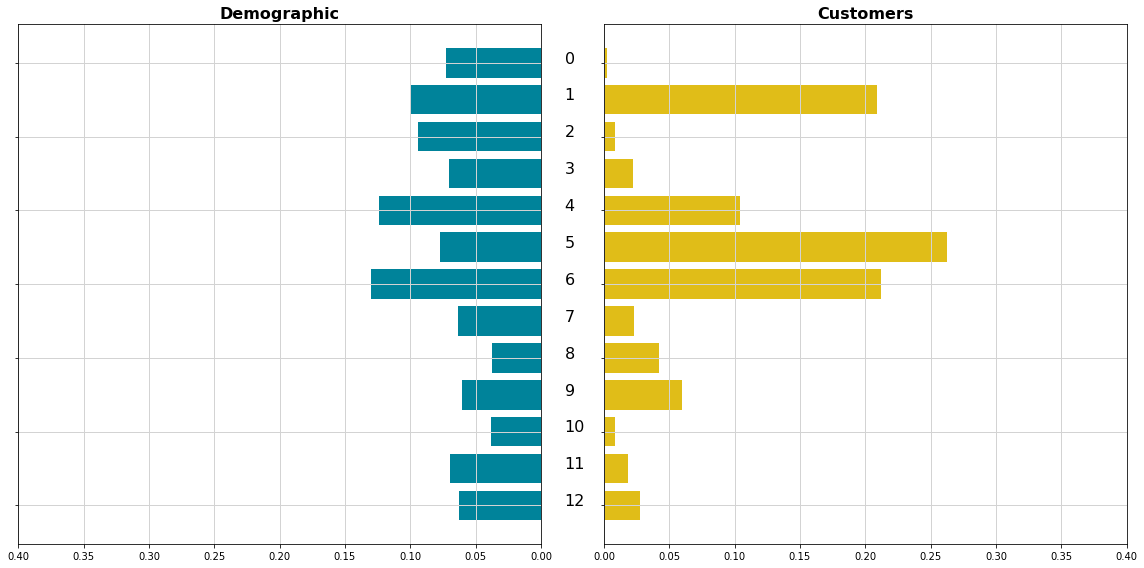

In [ ]:
fig = plt.figure(figsize=(16, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
ax0.barh(labels_df["labels"], labels_df["proportion"], color='#00839A')
ax0.set_title('Demographic', fontsize=16, fontweight='bold')
ax0.set_xlim([0, 0.4])
ax0.tick_params(axis='both', which='major')
plt.gca().invert_yaxis()
plt.grid(color='grey', linestyle='-', linewidth=.1)
plt.gca().invert_xaxis()
plt.gca().axes.yaxis.set_ticklabels([])
ax0.grid(color='lightgrey', linestyle='-', linewidth=1)
ax0.set_facecolor("white")
plt.tight_layout()

ax1 = plt.subplot(gs[1])
ax1.barh(labels_customer_df["labels"], labels_customer_df["proportion"], color='#E0BD18')
ax1.set_title('Customers', fontsize=16, fontweight='bold')
ax1.set_xlim([0, 0.4])
ax1.tick_params(axis='both', which='major')
plt.gca().invert_yaxis()
plt.gca().axes.yaxis.set_ticklabels([])

for i in range(0, 13):
  ax1.text(-0.03, i, f"{i}", fontsize=16)

ax1.grid(color='lightgrey', linestyle='-', linewidth=1)
ax1.set_facecolor("white")
plt.tight_layout()

In [ ]:
proportions = dict()

for cluster in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:

  customer_proportion = labels_customer_df.loc[labels_customer_df["labels"] == cluster]["proportion"].values[0]
  demographic_proportion = labels_df.loc[labels_df["labels"] == cluster]["proportion"].values[0]
  diff = customer_proportion - demographic_proportion

  proportions[cluster] = diff

ratio_df = pd.DataFrame.from_dict(proportions, orient='index', columns=["prop_ratio"])
ratio_df

,prop_ratio
0,-0.070102
1,0.109578
2,-0.085031
3,-0.047782
4,-0.020463
5,0.185477
6,0.082023
7,-0.040873
8,0.004756
9,-0.001286


(-0.1, 0.2)

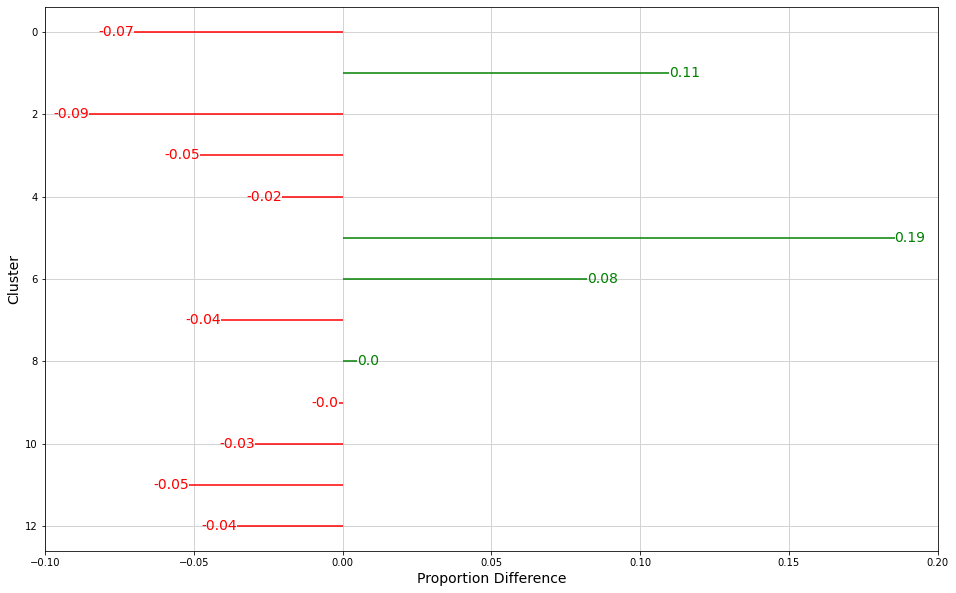

In [ ]:
# Colorize red for negative and green for positive ratio
ratio_df['colors'] = ['red' if x < 0 else 'green' for x in ratio_df['prop_ratio']]

fig, ax = plt.subplots(figsize=(16, 10))
ax.invert_yaxis()

ax.hlines(y=ratio_df.index, xmin=0, xmax=ratio_df["prop_ratio"], color=ratio_df["colors"])
for x, y, tex in zip(ratio_df["prop_ratio"], ratio_df.index, ratio_df["prop_ratio"]):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})

plt.xlabel("Proportion Difference", fontsize=14)
plt.ylabel("Cluster", fontsize=14)
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
plt.xlim(-0.1, 0.2)

### Analyze features for specific clusters

In [ ]:
df_customers_transformed["labels"] = labels_customer
df_customers_transformed_grouped = df_customers_transformed.groupby('labels').mean()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,

In [ ]:
# Save df_customers_transformed_grouped
df_customers_transformed_grouped.to_csv("df_customers_transformed_grouped.csv")
files = drive.CreateFile({'title' : "df_customers_transformed_grouped.csv"})
files.SetContentFile("df_customers_transformed_grouped.csv")
files.Upload()
drive.CreateFile({'id': files.get("df_customers_transformed_grouped.csv.csv")})

In [ ]:
download_data = drive.CreateFile({'id': '1wGt5mk9aoTLmTghCoz9fA5v1asGf2NRV'})
download_data.GetContentFile('df_customers_transformed.csv')  
df_customers_transformed = pd.read_csv('df_customers_transformed.csv', engine="python")

In [ ]:
df_customers_transformed

,labels,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_W

In [ ]:
col_df = pd.DataFrame(df_customers_transformed.columns.tolist(), columns=["cols"])
col_df["max_1"] = None
col_df["max_2"] = None
col_df["max_3"] = None
col_df["min_1"] = None
col_df["min_2"] = None
col_df["min_3"] = None  

for i in range(0, col_df.shape[0]):
  
  col = col_df["cols"][i]

  maxs = df_customers_transformed[col].nlargest(3).index.tolist()

  mins = df_customers_transformed[col].nsmallest(3).index.tolist()

  col_df["max_1"][i] = maxs[0]
  col_df["max_2"][i] = maxs[1]
  col_df["max_3"][i] = maxs[2]
  col_df["min_1"][i] = mins[0]
  col_df["min_2"][i] = mins[1]
  col_df["min_3"][i] = mins[2]

col_df

,cols,max_1,max_2,max_3,min_1,min_2,min_3
0,labels,12,11,10,0,1,2
1,ALTER_HH,8,1,12,10,4,6
2,ANZ_HAUSHALTE_AKTIV,9,3,10,1,6,5
3,ANZ_HH_TITEL,9,10,3,6,2,1
4,ANZ_KINDER,1,8,12,4,10,6
...,...,...,...,...,...,...,...
368,CAMEO_DEUG_2015_6,10,4,11,3,1,5
369,CAMEO_DEUG_2015_7,3,12,4,5,1,8
370,CAMEO_DEUG_2015_8,11,0,3,1,5,6
371,CAMEO_DEUG_2015_9,3,0,10,5,1,6


#### Cluster 1

In [ ]:
col_df.loc[(col_df["max_1"] == 1)]

,cols,max_1,max_2,max_3,min_1,min_2,min_3
4,ANZ_KINDER,1,8,12,4,10,6
14,D19_BANKEN_LOKAL,1,8,7,0,3,4
18,D19_BEKLEIDUNG_GEH,1,8,12,0,10,2
19,D19_BEKLEIDUNG_REST,1,8,12,10,0,4
20,D19_BILDUNG,1,8,12,0,2,10
21,D19_BIO_OEKO,1,8,12,0,2,6
22,D19_BUCH_CD,1,8,5,10,0,2
24,D19_DROGERIEARTIKEL,1,8,12,10,4,6
26,D19_FREIZEIT,1,8,12,10,4,6
27,D19_GARTEN,1,8,7,0,3,4


In [ ]:
len(col_df.loc[(col_df["max_1"] == 1)])

48

In [ ]:
len(col_df.loc[(col_df["min_1"] == 1)])

15

In [ ]:
col_df.loc[(col_df["min_1"] == 1)]

,cols,max_1,max_2,max_3,min_1,min_2,min_3
2,ANZ_HAUSHALTE_AKTIV,9,3,10,1,6,5
6,ANZ_STATISTISCHE_HAUSHALTE,9,10,3,1,6,5
66,FINANZ_HAUSBAUER,11,4,10,1,8,5
83,KBA05_ANTG3,11,0,3,1,6,5
84,KBA05_ANTG4,3,10,9,1,6,5
86,KBA05_BAUMAX,3,9,11,1,6,5
223,KBA13_PEUGEOT,3,11,12,1,6,10
265,PLZ8_ANTG3,3,11,0,1,6,7
271,RELAT_AB,3,9,0,1,6,2
289,W_KEIT_KIND_HH,10,4,9,1,8,12


**Cluster 1**

HIGH
- CAMEO_DEUG_2015_2: Upper middle class HIGH
- CJT_GESAMTTYP_3.0: Advertising interested store shopper
- PRAEGENDE_JUGENDJAHRE_70.0: seventies
- GFK_URLAUBERTYP_10.0: Connoisseurs
- GEBAUEDETYP_1.0: residental building
- MOBI_REGIO:  very low mobility
- LP_STATUS_FEIN: Top earners
- ANZAHL_KINDER: number of children


LOW
- ANZ_HAUSHALTE_AKTIV: Lowest anzahl haushalte
- FINANZ_HAUSBAUER: Main focus is own house
- CAMEO_DEUG_2015_8: Working class LOW
- W_KEIT_KIND_HH: Very likely that children are in household
- RELAT_AB: Very low share of unemployed in county
- CAMEO_INTL_2015_4 + CAMEO_INTL_2015_5: Not poor


In [ ]:
col_df.loc[(col_df["max_1"] == 5)]

,cols,max_1,max_2,max_3,min_1,min_2,min_3
7,ANZ_TITEL,5,9,8,10,2,0
67,FINANZ_MINIMALIST,5,1,6,0,10,3
73,GREEN_AVANTGARDE,5,8,1,10,0,11
79,KBA05_ALTER4,5,9,11,3,7,0
89,KBA05_CCM3,5,9,8,11,7,0
90,KBA05_CCM4,5,9,8,11,7,0
100,KBA05_KRSAQUOT,5,1,8,3,0,4
101,KBA05_KRSHERST1,5,9,8,0,3,4
102,KBA05_KRSHERST2,5,9,1,11,0,4
105,KBA05_KRSOBER,5,9,7,0,3,4


In [ ]:
col_df.loc[(col_df["min_1"] == 5)]

,cols,max_1,max_2,max_3,min_1,min_2,min_3
65,FINANZ_ANLEGER,2,0,7,5,9,4
74,HH_EINKOMMEN_SCORE,0,11,3,5,8,1
76,KBA05_ALTER1,7,10,0,5,9,8
77,KBA05_ALTER2,3,2,0,5,11,9
88,KBA05_CCM2,11,7,0,5,9,8
99,KBA05_HERSTTEMP,11,7,0,5,9,10
104,KBA05_KRSKLEIN,4,0,3,5,9,10
108,KBA05_KW1,7,0,3,5,9,8
115,KBA05_MAXVORB,10,0,3,5,9,11
121,KBA05_MODTEMP,10,7,4,5,9,8


**Cluster 5**

HIGH:
- TITEL_KZ: indicates many people with Dr./Prof.
- PRAEGENDE_JUGENDJAHRE_50.0: fifties
- CAMEO_DEUG_2015_1: Upper class
- CAMEO_INTL_2015_1: Wealthy households
- LP_STATUS_GROB: top earnes
- SEMIO_VERT: affinity indicating in what way the person is dreamily (LOW)
- GREEN_AVANTGARDE: the environmental sustainability is the dominating movement in the youth of these consumers	
- FINANZ_MINIMALIST: HIGH -> indicates low


LOW:
- WOHNLAGE: very good neighbourhood
- CAMEO_DEUG_2015_7 + CAMEO_DEUG_2015_9: Not working class/lower middle class
- SEMIO_KAEM: Low fitfull attitude
- REGIOTYP: Neighborhood is upper class
- KKK: Purchasing power is very high
- HH_EINKOMMEN_SCORE: indicates highest income
- FINANZ_ANLEGER: inidcates high probability to be a investor




In [ ]:
col_df.loc[(col_df["max_1"] == 6)]

,cols,max_1,max_2,max_3,min_1,min_2,min_3
70,FINANZ_VORSORGER,6,4,5,0,2,7
75,INNENSTADT,6,7,1,3,9,12
178,KBA13_HALTER_50,6,7,1,3,9,11
179,KBA13_HALTER_55,6,1,2,3,9,11
187,KBA13_HERST_FORD_OPEL,6,0,1,9,5,3
222,KBA13_OPEL,6,0,1,9,5,3
249,KBA13_VW,6,1,2,11,12,0
262,OST_WEST_KZ,6,2,1,11,7,3
293,ALTERSKATEGORIE_GROB,6,4,5,0,2,12
303,GEBAEUDETYP_2.0,6,2,5,0,10,11


**Cluster 6**

HIGH:
- FINANZ_VORSORGER: Low prob to be the type financial prepared
- INNENSTADT: urban
- OST_WEST_KZ: west germany
- ALTERSKATEGORIE_GROB: older
- SHOPPER_TYPE_0.0: external supplied hedonists 
- NATIONALITAET_KZ_1.0: Sounding german
- GFK_URLAUBERTYP_7.0:Golden ager
- FINANZTYP_2.0: money saver
- CJT_GESAMTTYP_2.0: Advertising- and Consumptiontraditionalist


LOW:
- FINANZ_SPARER: Money saver
- PLZ8_BAUMAX: mainly 1-2 family homes
- SEMIO_DOM: affinity indicating in what way the person is dominant minded (HIGH)
- SEMIO_MAT: affinity indicating in what way the person is material minded
- SEMIO_RAT: affinity indicating in what way the person is of a rational mind






In [ ]:
col_df.loc[(col_df["min_1"] == 6)]

,cols,max_1,max_2,max_3,min_1,min_2,min_3
3,ANZ_HH_TITEL,9,10,3,6,2,1
13,D19_BANKEN_GROSS,8,12,1,6,4,10
68,FINANZ_SPARER,0,2,12,6,5,4
169,KBA13_FAB_SONSTIGE,7,11,3,6,1,2
188,KBA13_HERST_SONST,7,11,3,6,1,2
267,PLZ8_BAUMAX,3,11,9,6,1,2
273,SEMIO_DOM,10,12,9,6,7,1
280,SEMIO_MAT,0,2,12,6,11,4
282,SEMIO_RAT,0,2,10,6,5,4
307,GEBAEUDETYP_8.0,3,9,11,6,1,7


# Part 2: Supervised

### Functions for supervised learning

In [17]:
# Transformer
class PreprocessFeatures(BaseEstimator, TransformerMixin):
    '''
    Counts the occurence of given symbols in given text.
    '''
    def __init__(self, column_threshold = 0.2, row_threshold = 0.1):
        self.column_threshold = column_threshold
        self.row_threshold = row_threshold
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
      print(f"shape before: {df.shape}")
      
      # Drop ID column
      df = df.drop(columns="LNR")
      print("index droped")

      # Drop columns with nan percentage over certain threshold
      drop_columns = meta_data.loc[meta_data["na_percentage_azdias"] > self.column_threshold]["column_name"].tolist()
      df = df.drop(columns=drop_columns)
      print(f"columns with nan threshold of {self.column_threshold} droped: ")
      print(drop_columns)

      ### Drop columns with unknown data types and no description ###

      unknown_cols = meta_data.loc[meta_data["type"] == "Unknown"]["column_name"].tolist()
      df_transformed = df.drop(columns=list(set(unknown_cols).intersection(set(df.columns))))
      print("columns with unknown datatype droped")

      ### Transformation of binary columns ###

      df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].replace(2, 0) 
      df_transformed["GREEN_AVANTGARDE"] = df_transformed["GREEN_AVANTGARDE"].fillna(df_transformed["GREEN_AVANTGARDE"].mode().values[0])
      df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].apply(lambda x: 1 if x == 'W' else (0 if 'O' else x))
      df_transformed["SOHO_KZ"] = df_transformed["SOHO_KZ"].fillna(df_transformed["SOHO_KZ"].mode().values[0])
      df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].fillna(df_transformed["ANREDE_KZ"].mode().values[0])
      df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].fillna(df_transformed["OST_WEST_KZ"].mode().values[0])
      print("binary columns transformed")

      ### Transformation of numerical columns ###

      numerical_columns = meta_data.loc[meta_data["type"] == "Numerical"]["column_name"].tolist()
      for col in list(set(numerical_columns).intersection(set(df_transformed.columns))):
        df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
      print("numeric columns transformed")

      ### Transformation of ordinal columns ###

      # Transform ordinal columns that have no value or -1 for unknown
      ordinal_no_unknown_cols = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] != 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
      ordinal_no_unknown_cols = list(set(ordinal_no_unknown_cols).intersection(set(df_transformed.columns)))
      for col in ordinal_no_unknown_cols:
        df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
      print("ordinal columns that have no value for unkown transformed")

      # Transform ordinal colums that have 9 or -1 values for unknow
      ordinal_9_1_cols = meta_data.loc[(meta_data["9 unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
      ordinal_9_1_cols = list(set(ordinal_9_1_cols).intersection(set(df_transformed.columns)))
      for col in ordinal_9_1_cols:
        df_transformed[col] = df_transformed[col].replace(9, np.nan).fillna(df_transformed[col].median())
      print("ordinal colums that have 9 or -1 values for unknow transformed")

      # Transform ordinal columns that have 0 or -1 values for unknown
      ordinal_0_1_cols = meta_data.loc[(meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
      ordinal_0_1_cols = list(set(ordinal_0_1_cols).intersection(set(df_transformed.columns)))
      for col in ordinal_0_1_cols:
        df_transformed[col] = df_transformed[col].replace(0, np.nan).fillna(df_transformed[col].median())
      print("ordinal colums that have 0 or -1 values for unknow transformed")

      ### Transformation of categorical features ###

      # Transform categorical columns that have 0 values for unknown
      categorical_0_columns = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Categorical")]["column_name"].tolist()
      categorical_0_columns = list(set(categorical_0_columns).intersection(set(df_transformed.columns)))
      for col in categorical_0_columns:
        df_transformed[col] = df_transformed[col].replace({-1: np.nan, 0: np.nan})
      print("categorical columns that have 0 values for unknown transformed")

      # Transform "PRAEGENDE_JUGENDJAHRE"
      df_transformed["PRAEGENDE_JUGENDJAHRE"] = df_transformed["PRAEGENDE_JUGENDJAHRE"].apply(transform_PRAEGENDE_JUGENDJAHRE)
      print('"PRAEGENDE_JUGENDJAHRE" transformed')

      # Transform "ZABEOTYP"
      df_transformed["ZABEOTYP"] = df_transformed["ZABEOTYP"].replace({9: np.nan})
      print('"ZABEOTYP" transformed')

      # Transform "D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"
      cat_temp = ["D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"]
      cat_temp = list(set(cat_temp).intersection(set(df_transformed.columns)))
      for col in cat_temp:
        df_transformed[col] = df_transformed[col].replace({-1: np.nan})
      print('"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed')

      # Drop "CAMEO_DEU_2015" and "AGER_TYP"
      df_transformed = df_transformed.drop(columns=["CAMEO_DEU_2015", "AGER_TYP"])
      print('"CAMEO_DEU_2015" and "AGER_TYP" droped')

      # Transform "CAMEO_INTL_2015"
      df_transformed["CAMEO_INTL_2015"] = df_transformed["CAMEO_INTL_2015"].apply(transform_CAMEO_INTL_2015)
      print("CAMEO_INTL_2015 transformed")

      # Transform "CAMEO_DEUG_2015"
      df_transformed["CAMEO_DEUG_2015"] = df_transformed["CAMEO_DEUG_2015"].apply(transform_CAMEO_DEUG_2015)
      print("CAMEO_DEUG_2015 transformed")

      # Create dummies
      cat_cols = meta_data.loc[meta_data["type"] == "Categorical"]["column_name"].tolist()
      print(cat_cols)
      dummy_cols = list(set(cat_cols).intersection(set(df_transformed.columns)))
      print(dummy_cols)
      for col in dummy_cols:
        col_dum_df = pd.get_dummies(df_transformed[col], prefix=col, dummy_na=True)
        df_transformed = pd.concat([df_transformed, col_dum_df], axis=1)

      df_transformed = df_transformed.drop(columns=dummy_cols)
      print("Dummies created")

      # Transform everything to float
      df_transformed = df_transformed.astype(float)

      print(f"shape after: {df_transformed.shape}")
      return df_transformed
        

In [18]:
def build_pipeline(model, scaling_transformer=False, pca_transformer=False, smote_transformer=False,
                   undersampling_transformer=False, explained_variance=0.9, smote_sampling_strategy=0.1, under_sampling_strategy=0.5):
  
  
  steps=[('scaler', StandardScaler()),
         ('pca', PCA(explained_variance)),
         ('smote', SMOTE(sampling_strategy=smote_sampling_strategy)),
         ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy)),
         ('model', model)]

  pipline_elements = [element[0] for element in steps]

  if(scaling_transformer==False):
     index = pipline_elements.index('scaler')
     pipline_elements.pop(index)
     steps.pop(index)

  if(pca_transformer==False):
    index = pipline_elements.index('pca')
    pipline_elements.pop(index)
    steps.pop(index)
    
  if(smote_transformer==False):
    index = pipline_elements.index('smote')
    pipline_elements.pop(index)
    steps.pop(index)
    
  if(undersampling_transformer==False):
    index = pipline_elements.index('under')
    pipline_elements.pop(index)
    steps.pop(index)
  
  pipeline = Pipeline(steps)

  return pipeline

In [19]:
def evaluate_models(X, Y, models):

  for model in models:
    
    # Build pipeline
    pipeline = build_pipeline(model, scaling_transformer=False, pca_transformer=False, smote_transformer=False, undersampling_transformer=False)
    print("Pipeline: ")
    print(pipeline)
    
    # Evaluate pipeline
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print(f"Model: {model}")
    print('Mean ROC AUC: %.3f' % np.mean(scores))
    print("__________________________________________")

In [20]:
# Prepare data and split into X (features) and Y (labels)
Y = np.array(df_train["RESPONSE"])
df_train_X = df_train.drop(columns="RESPONSE")
preprocesser = PreprocessFeatures()
X = np.array(preprocesser.fit_transform(df_train_X))

shape before: (42962, 366)
index droped
columns with nan threshold of 0.2 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
columns with unknown datatype droped
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_2015 transformed
CAMEO_DEUG_2015 transform

### Determing the best algorithm

In [ ]:
models = [XGBRegressor(), AdaBoostClassifier(), RandomForestClassifier()]
evaluate_models(X, Y, models)

Pipeline: 
Pipeline(memory=None,
         steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
         verbose=False)
Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
            

### XGBoost Hyperparameter Tuning

In [ ]:
# Without scaling
xgb_model1 = XGBRegressor(objective = "binary:logistic")

pipeline1 = build_pipeline(xgb_model1, scaling_transformer=False, pca_transformer=False, smote_transformer=False, undersampling_transformer=False)

params1 = {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [50, 100]
        }

grid_search1 = GridSearchCV(pipeline1, params1, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1, n_jobs=-1)

print(pipeline1)

grid_search1.fit(X, Y)

print(f"Best parameters: {grid_search1.best_params_}")
print(f"Best score: {grid_search1.best_score_}")

In [ ]:
# With scaling
xgb_model2 = XGBRegressor(objective = "binary:logistic")

pipeline2 = build_pipeline(xgb_model2, scaling_transformer=True, pca_transformer=False, smote_transformer=False, undersampling_transformer=False)

params2 = {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [50, 100]
        }

grid_search2 = GridSearchCV(pipeline2, params2, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1, n_jobs=-1)

print(pipeline2)

grid_search2.fit(X, Y)

print(f"Best parameters: {grid_search2.best_params_}")
print(f"Best score: {grid_search2.best_score_}")

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
         verbose=False)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.8min finished


Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 50}
Best score: 0.5323163998101076


In [ ]:
# With scaling and PCA (190 components)
xgb_model3 = XGBRegressor(objective = "binary:logistic")

pipeline3 = build_pipeline(xgb_model3, scaling_transformer=True, pca_transformer=True, smote_transformer=False, undersampling_transformer=False,
                          n_pca_components=190)

params3 = {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [50, 100]
        }

grid_search3 = GridSearchCV(pipeline3, params3, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1, n_jobs=-1)

print(pipeline3)

grid_search3.fit(X, Y)

print(f"Best parameters: {grid_search3.best_params_}")
print(f"Best score: {grid_search3.best_score_}")

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=190,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.2min finished


Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
Best score: 0.5283451624015624


In [ ]:
# With scaling and PCA (70 components)
xgb_model4 = XGBRegressor(objective = "binary:logistic")

pipeline4 = build_pipeline(xgb_model4, scaling_transformer=True, pca_transformer=True, smote_transformer=False, undersampling_transformer=False,
                          n_pca_components=70)

params4 = {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [50, 100]
        }

grid_search4 = GridSearchCV(pipeline4, params4, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1, n_jobs=-1)

print(pipeline4)

grid_search4.fit(X, Y)

print(f"Best parameters: {grid_search4.best_params_}")
print(f"Best score: {grid_search4.best_score_}")

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=70,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.6min finished


Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
Best score: 0.5222012581386967


In [ ]:
# With scaling and PCA (10 components)
xgb_model5 = XGBRegressor(objective = "binary:logistic")

pipeline5 = build_pipeline(xgb_model5, scaling_transformer=True, pca_transformer=True, smote_transformer=False, undersampling_transformer=False,
                          n_pca_components=70)

params5 = {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [50, 100]
        }

grid_search5 = GridSearchCV(pipeline5, params5, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1, n_jobs=-1)

print(pipeline5)

grid_search5.fit(X, Y)

print(f"Best parameters: {grid_search5.best_params_}")
print(f"Best score: {grid_search5.best_score_}")

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=70,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished


Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
Best score: 0.5228804302359403


In [ ]:
# With scaling, oversamping and undersampling (without PCA)
xgb_model6 = XGBRegressor(objective = "binary:logistic")

pipeline6 = build_pipeline(xgb_model6, scaling_transformer=True, pca_transformer=False, smote_transformer=True, undersampling_transformer=True,
                          smote_sampling_strategy=0.2, under_sampling_strategy=0.5)

params6 = {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [50, 100]
        }

grid_search6 = GridSearchCV(pipeline6, params6, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1, n_jobs=-1)


print(pipeline6)

grid_search6.fit(X, Y)

print(f"Best parameters: {grid_search6.best_params_}")
print(f"Best score: {grid_search6.best_score_}")

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy=0.2, svm_estimator='deprecated')),
                ('under',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=Fals...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
Best score: 0.54234575599181


### New transformer pipeline

In [21]:
def transformation_pipeline_supervised(df, column_threshold = 0.3):

  print(f"shape before: {df.shape}")

  # Drop ID column
  df = df.drop(columns="LNR")
  print("index droped")

  # Drop columns with nan percentage over certain threshold
  drop_columns = meta_data.loc[meta_data["na_percentage_azdias"] > column_threshold]["column_name"].tolist()
  df_transformed = df.drop(columns=drop_columns)
  print(f"columns with nan threshold of {column_threshold} droped: ")
  print(drop_columns)

  ### Drop columns with unknown data types and no description ###

  unknown_cols = meta_data.loc[meta_data["type"] == "Unknown"]["column_name"].tolist()

  for col in list(set(unknown_cols).intersection(set(df_transformed.columns))):

    if(col == "EINGEFUEGT_AM"):
      df_transformed = df_transformed.drop(columns=col)

    elif(col == "D19_LETZTER_KAUF_BRANCHE"):
      col_dum_df = pd.get_dummies(df_transformed[col], prefix=col, dummy_na=True)
      df_transformed = pd.concat([df_transformed, col_dum_df], axis=1)
      df_transformed = df_transformed.drop(columns=col)

    else:
      df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("columns with unknown datatype imputed")

  ### Transformation of binary columns ###

  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].replace(2, 0) 
  df_transformed["GREEN_AVANTGARDE"] = df_transformed["GREEN_AVANTGARDE"].fillna(df_transformed["GREEN_AVANTGARDE"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].apply(lambda x: 1 if x == 'W' else (0 if 'O' else x))
  df_transformed["SOHO_KZ"] = df_transformed["SOHO_KZ"].fillna(df_transformed["SOHO_KZ"].mode().values[0])
  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].fillna(df_transformed["ANREDE_KZ"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].fillna(df_transformed["OST_WEST_KZ"].mode().values[0])
  print("binary columns transformed")

  ### Transformation of numerical columns ###

  numerical_columns = meta_data.loc[meta_data["type"] == "Numerical"]["column_name"].tolist()
  for col in list(set(numerical_columns).intersection(set(df_transformed.columns))):
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("numeric columns transformed")

  ### Transformation of ordinal columns ###

  # Transform ordinal columns that have no value or -1 for unknown
  ordinal_no_unknown_cols = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] != 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_no_unknown_cols = list(set(ordinal_no_unknown_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_no_unknown_cols:
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("ordinal columns that have no value for unkown transformed")

  # Transform ordinal colums that have 9 or -1 values for unknow
  ordinal_9_1_cols = meta_data.loc[(meta_data["9 unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_9_1_cols = list(set(ordinal_9_1_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_9_1_cols:
    df_transformed[col] = df_transformed[col].replace(9, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 9 or -1 values for unknow transformed")

  # Transform ordinal columns that have 0 or -1 values for unknown
  ordinal_0_1_cols = meta_data.loc[(meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_0_1_cols = list(set(ordinal_0_1_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_0_1_cols:
    df_transformed[col] = df_transformed[col].replace(0, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 0 or -1 values for unknow transformed")

  ### Transformation of categorical features ###

  # Transform categorical columns that have 0 values for unknown
  categorical_0_columns = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Categorical")]["column_name"].tolist()
  categorical_0_columns = list(set(categorical_0_columns).intersection(set(df_transformed.columns)))
  for col in categorical_0_columns:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan, 0: np.nan})
  print("categorical columns that have 0 values for unknown transformed")

  # Transform "PRAEGENDE_JUGENDJAHRE"
  df_transformed["PRAEGENDE_JUGENDJAHRE"] = df_transformed["PRAEGENDE_JUGENDJAHRE"].apply(transform_PRAEGENDE_JUGENDJAHRE)
  print('"PRAEGENDE_JUGENDJAHRE" transformed')

  # Transform "ZABEOTYP"
  df_transformed["ZABEOTYP"] = df_transformed["ZABEOTYP"].replace({9: np.nan})
  print('"ZABEOTYP" transformed')

  # Transform "D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"
  cat_temp = ["D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"]
  cat_temp = list(set(cat_temp).intersection(set(df_transformed.columns)))
  for col in cat_temp:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan})
  print('"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed')

  # Drop "CAMEO_DEU_2015" and "AGER_TYP"
  df_transformed = df_transformed.drop(columns=["CAMEO_DEU_2015", "AGER_TYP"])
  print('"CAMEO_DEU_2015" and "AGER_TYP" droped')

  # Transform "CAMEO_INTL_2015"
  df_transformed["CAMEO_INTL_2015"] = df_transformed["CAMEO_INTL_2015"].apply(transform_CAMEO_INTL_2015)
  print("CAMEO_INTL_2015 transformed")

  # Transform "CAMEO_DEUG_2015"
  df_transformed["CAMEO_DEUG_2015"] = df_transformed["CAMEO_DEUG_2015"].apply(transform_CAMEO_DEUG_2015)
  print("CAMEO_DEUG_2015 transformed")

  # Create dummies
  cat_cols = meta_data.loc[meta_data["type"] == "Categorical"]["column_name"].tolist()
  print(cat_cols)
  dummy_cols = list(set(cat_cols).intersection(set(df_transformed.columns)))
  print(dummy_cols)
  for col in dummy_cols:
    col_dum_df = pd.get_dummies(df_transformed[col], prefix=col, dummy_na=True)
    df_transformed = pd.concat([df_transformed, col_dum_df], axis=1)

  df_transformed = df_transformed.drop(columns=dummy_cols)
  print("Dummies created")

  # Transform everything to float
  df_transformed = df_transformed.astype(float)

  print(f"shape after: {df_transformed.shape}")
  return df_transformed

In [27]:
# Prepare data and split into X (features) and Y (labels)
Y = np.array(df_train["RESPONSE"])
df_train_X = df_train.drop(columns="RESPONSE")
df_train_X = transformation_pipeline_supervised(df_train_X)
X = np.array(df_train_X)

shape before: (42962, 366)
index droped
columns with nan threshold of 0.3 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
columns with unknown datatype imputed
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_2015 transformed
CAMEO_DEUG_2015 transformed
['AGER_TYP', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'ZABEOTYP']
['PRAEG

In [38]:
# With scaling, oversamping and undersampling
xgb_model = XGBRegressor(objective = "binary:logistic")

pipeline = build_pipeline(xgb_model,
                          scaling_transformer=True,
                          pca_transformer=False,
                          smote_transformer=True,
                          undersampling_transformer=True,
                          smote_sampling_strategy=0.2,
                          under_sampling_strategy=0.5)

params = {
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [3, 4, 5],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__min_child_weight': [1, 5, 10],
        }

rand_grid_search = RandomizedSearchCV(pipeline, params, n_iter=20,
                                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                      scoring='roc_auc', verbose=1, n_jobs=-1,
                                      random_state=42)

print(pipeline)

rand_grid_search.fit(X, Y)

print(f"Best parameters: {rand_grid_search.best_params_}")
print(f"Best score: {rand_grid_search.best_score_}")

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy=0.2, svm_estimator='deprecated')),
                ('under',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=Fals...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 90.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 50, 'model__min_child_weight': 5, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__gamma': 2}
Best score: 0.7386933619088945


In [40]:
# With scaling, oversamping and undersampling
rand_grid_search.cv_results_

{'mean_fit_time': array([ 22.55807085,  58.09297357, 260.44609456,  30.3713202 ,
        178.22152271, 316.45047746,  29.41835003,  37.26692147,
        279.34258008,  48.53661923,  57.59249692,  24.9117393 ,
         45.28623161,  33.90377855,  70.4296535 , 283.40531707,
         25.49173789,  45.06867199, 261.44434319,  64.82136464]),
 'mean_score_time': array([0.0974905 , 0.12463317, 0.30852275, 0.10875521, 0.25012088,
        0.24887652, 0.10421247, 0.12013001, 0.33676314, 0.13339257,
        0.13109126, 0.10455661, 0.10961146, 0.11358147, 0.14813328,
        0.32187548, 0.10434356, 0.12646775, 0.32930865, 0.13457379]),
 'mean_test_score': array([0.73869336, 0.70168238, 0.68426557, 0.68816214, 0.68617765,
        0.65864465, 0.72608941, 0.68459754, 0.67491138, 0.68921192,
        0.66478906, 0.68385718, 0.7289065 , 0.68475539, 0.68630205,
        0.6847622 , 0.68486282, 0.67208119, 0.68197601, 0.66793416]),
 'param_model__gamma': masked_array(data=[2, 2, 0.5, 0.5, 1.5, 2, 1, 1.5, 0

In [41]:
# With scaling, PCA, oversamping and undersampling
xgb_model = XGBRegressor(objective = "binary:logistic")

pipeline = build_pipeline(xgb_model,
                          scaling_transformer=True,
                          pca_transformer=True,
                          smote_transformer=True,
                          undersampling_transformer=True,
                          smote_sampling_strategy=0.2,
                          under_sampling_strategy=0.5)

params = {
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [3, 4, 5],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__min_child_weight': [1, 5, 10],
        }

rand_grid_search = RandomizedSearchCV(pipeline, params, n_iter=20,
                                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                      scoring='roc_auc', verbose=1, n_jobs=-1,
                                      random_state=42)

print(pipeline)

rand_grid_search.fit(X, Y)

print(f"Best parameters: {rand_grid_search.best_params_}")
print(f"Best score: {rand_grid_search.best_score_}")



Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampl...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 97.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'model__subsample': 1.0, 'model__n_estimators': 50, 'model__min_child_weight': 10, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 0.5}
Best score: 0.6002880988583974


In [42]:
# With scaling, PCA, oversamping and undersampling
rand_grid_search.cv_results_

{'mean_fit_time': array([ 27.34141703,  81.33402247, 281.60981717,  43.19797945,
        229.06795549, 305.80496569,  31.31126957,  51.4460865 ,
        257.23993769,  66.90182848,  57.45444417,  36.50559516,
         43.58702612,  40.84261241,  69.72528343, 259.19011569,
         35.89590759,  44.84208326, 286.96177888,  74.68819227]),
 'mean_score_time': array([0.21253781, 0.2339488 , 0.43167877, 0.20597792, 0.36727209,
        0.31851039, 0.20323939, 0.21463709, 0.44175863, 0.23303208,
        0.2289856 , 0.20282717, 0.21201062, 0.22574182, 0.26331935,
        0.43594265, 0.2060842 , 0.21719351, 0.43888812, 0.22829509]),
 'mean_test_score': array([0.56456064, 0.58461551, 0.592619  , 0.6002881 , 0.58765547,
        0.59117135, 0.57812108, 0.59183259, 0.59700612, 0.5907917 ,
        0.59399373, 0.58828976, 0.57986388, 0.57867227, 0.59548346,
        0.59339612, 0.59628558, 0.58279883, 0.59288738, 0.57473011]),
 'param_model__gamma': masked_array(data=[2, 2, 0.5, 0.5, 1.5, 2, 1, 1.5, 0

In [ ]:
# With scaling and PCA
xgb_model = XGBRegressor(objective = "binary:logistic")

pipeline = build_pipeline(xgb_model,
                          scaling_transformer=True,
                          pca_transformer=True,
                          smote_transformer=False,
                          undersampling_transformer=False,
                          smote_sampling_strategy=0.2,
                          under_sampling_strategy=0.5)

params = {
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [3, 4, 5],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__min_child_weight': [1, 5, 10],
        }

rand_grid_search = RandomizedSearchCV(pipeline, params, n_iter=20,
                                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                      scoring='roc_auc', verbose=1, n_jobs=-1,
                                      random_state=42)

print(pipeline)

rand_grid_search.fit(X, Y)

print(f"Best parameters: {rand_grid_search.best_params_}")
print(f"Best score: {rand_grid_search.best_score_}")



Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 86.5min


In [ ]:
# With scaling and PCA
rand_grid_search.cv_results_

In [ ]:
# Only with scaling
xgb_model = XGBRegressor(objective = "binary:logistic")

pipeline = build_pipeline(xgb_model,
                          scaling_transformer=True,
                          pca_transformer=False,
                          smote_transformer=False,
                          undersampling_transformer=False,
                          smote_sampling_strategy=0.2,
                          under_sampling_strategy=0.5)

params = {
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [3, 4, 5],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__min_child_weight': [1, 5, 10],
        }

rand_grid_search = RandomizedSearchCV(pipeline, params, n_iter=20,
                                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                      scoring='roc_auc', verbose=1, n_jobs=-1,
                                      random_state=42)

print(pipeline)

rand_grid_search.fit(X, Y)

print(f"Best parameters: {rand_grid_search.best_params_}")
print(f"Best score: {rand_grid_search.best_score_}")



In [ ]:
# Only with scaling
rand_grid_search.cv_results_

In [ ]:
df_ids = pd.DataFrame(df_test["LNR"])
df_ids

,LNR
0,1754
1,1770
2,1465
3,1470
4,1478
...,...
42828,67615
42829,67938
42830,67942
42831,67949


In [ ]:
X_test = np.array(transformation_pipeline_supervised(df_test))

shape before: (42833, 366)
index droped
columns with nan threshold of 0.3 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
columns with unknown datatype Inputed
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_2015 transformed
CAMEO_DEUG_2015 transformed
['AGER_TYP', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'ZABEOTYP']
['FINAN

In [ ]:
predictions = grid_search.predict(X_test)

In [ ]:
predictions.shape

(42833,)